In [1]:
from logs import logDecorator as lD 
import jsonref, pprint
from lib.databaseIO import pgIO

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import plotly.graph_objects as go

In [2]:
config = jsonref.load(open('../config/config.json'))
logBase = config['logging']['logBase'] + '.modules.module1.module1'
projConfig = jsonref.load(open('../config/modules/module1.json'))

# Querying Data
For the first run, need to download data from the database. <br> 
For subsequent runs, just load from pickle file.

In [3]:
@lD.log(logBase + '.getData')
def getData(logger, query, cols=[], saveData=True, savePath='temp'):

    dbName = projConfig['inputs']['dbName']
    dbVersion = projConfig['inputs']['dbVersion']
    
    data = pgIO.getAllData(query, dbName=dbName)
    df = pd.DataFrame(data)
    if cols != []: df.columns = cols
    if saveData and not os.path.exists(f'../data/{savePath}.pkl'):
        df.to_pickle(f'../data/{savePath}.pkl')
    return df

## Filter for Patient Cohort
Get PatientID for cohort which meets the selection criteria:
1. the same medication was prescribed for at least 120 days; 
2. same medication for at least 120 days, an upper bound on the time; 
3. to exclude patients with wide gaps between visits, we only include patients with at least three visits of same medication during the 120-day time period.
4. Diagnosed with a specific **target disease**. 
    - This will reduce the size of the dataset and simplify the query.

In [53]:
disorders_dsmno = pd.read_csv('../data/raw_data/disorders_dsmno.csv')

Text(0.5, 1.0, 'Count of patient records by Mental Health Disorder Category')

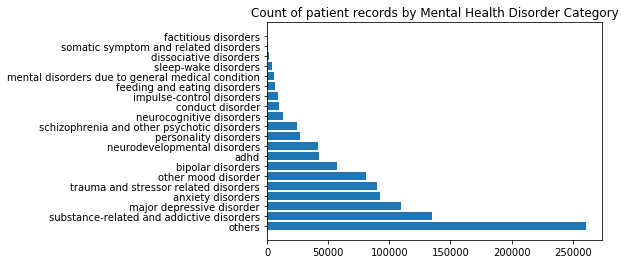

In [54]:
# from plotly import graph_objs as go
# ## testing with plotly
# fig = go.Figure([go.Bar(x=disorders_dsmno['disorders'], y=disorders_dsmno['counts'], orientation='h')])
# plotly.offline.plot(fig)

fig, ax = plt.subplots()
plt.barh(disorders_dsmno['disorders'], disorders_dsmno['counts'])
plt.title('Count of patient records by Mental Health Disorder Category')
# plt.yticks(labels=[f'{disorder} ({round(pct,1)}%)' for disorder, pct in zip(disorders_dsmno['disorders'], (disorders_dsmno['counts']/disorders_dsmno['counts'].sum())*100)])
for disorder, pct in zip(disorders_dsmno['disorders'], (disorders_dsmno['counts']/disorders_dsmno['counts'].sum())*100):
    ax.text(f'{round(pct, 1)}%')


In [114]:
# cohort_dsm = disorders_dsmno.loc[disorders_dsmno['disorders']=='major depressive disorder']['dsmno'].item()
## Issues with the string missing the '', like 'F33.0'
cohort_dsm = ('296.20', '296.21',     '296.22',    '296.23',    '296.24',    '296.25',
#                 '296.26',    'F32.0',    'F32.1',    'F32.2',    'F32.4',
#                 'F32.5',    'F32.81',    'F32.89',    '296.30',    '296.31',
#                 '296.32',    '296.33',    '296.34', '296.35',    '296.36',
#                 'F33.0',    'F33.1',    'F33.2',    'F33.40',    'F33.41',
#                 'F33.42',    'F33.8',    '311',    'F32.9',    'F33.9',
                '300.4',    'F34.1')

In [115]:
cohort_query = f"""select
        distinct pd.patientid, pd.typepatientid, tp.days
    from
        rwe_version1_2.pdiagnose pd, rwe_version1_2.typepatient as tp
    where pd.patientid in (
        select
            tp.patientid
        from
            rwe_version1_2.typepatient as tp,
            rwe_version1_2.meds as meds
        where
            tp.typepatientid = meds.typepatientid
        group by
            tp.patientid,
            meds.medication
        having
            max(tp.days) - min(tp.days) >= 120
            and count(distinct tp.typepatientid) >= 3 )
    and
        cast(pd.dsmno as text) in {cohort_dsm}
        and pd.primary_dx = true
        """

In [ ]:
all_pts_data = getData(cohort_query, 
#                        cols=['PatientID', 'VisitID','Days'], # Returns 0 columns for some reason? 
                       savePath='intermediate/cohort_visitsdays')
all_pts_data.columns = ['PatientID', 'VisitID', 'Days']
## Running into "your device is out of space errors"

In [117]:
# all_pts_data = pickle.load(open('../data/intermediate/cohort_visitsdays.pkl','rb'))
# all_pts_list = tuple([pt for pt in all_pts_data['PatientID']]) #for sql query

In [ ]:
# Some EDA about the frequency of patient visits
days_between_visits = all_pts_data.groupby('PatientID').agg({'Days':['count', 'max','min','mean','std']}) #.apply(list)
days_between_visits.head()#['Days']['count']

## Get Data of Patient Cohort
1. Separate tables
2. Full join

### Checking for Duplicates
Using distinct in the SQL queries to ensure that for each table, there's unique values.

In [9]:
cgi_query = f"""
    select tp.patientid, tp.typepatientid, cgi.severity
    from rwe_version1_2.typepatient tp, rwe_version1_2.cgi cgi
    where tp.typepatientid = cgi.typepatientid
    and tp.typepatientid in {visits_list}
"""

In [18]:
cgi_cols = ['PatientID', 'VisitID','CGI']
cgi_data = getData(cgi_query, cols=cgi_cols, saveData=False)

In [32]:
grp = cgi_data.groupby('VisitID')
grp['CGI'].count()[grp['CGI'].count() > 1]

Series([], Name: CGI, dtype: int64)

In [53]:
cgi_data.head()

,PatientID,VisitID,CGI
0,92,1681,1
1,9209,241608,4
2,9209,241613,4
3,9209,241576,2
4,9209,241603,3


In [10]:
meds_query = f"""
    select 
        distinct on (tp.patientid, tp.typepatientid, meds.medication)
        tp.patientid, tp.typepatientid, meds.medication, meds.dose, meds.regimen
    from rwe_version1_2.typepatient tp, rwe_version1_2.meds meds
    where tp.typepatientid = meds.typepatientid
    and tp.typepatientid in {visits_list}
"""

In [48]:
meds_cols = ['PatientID', 'VisitID','Medication','Dose', 'Regimen']
meds_data = getData(meds_query, cols=meds_cols, saveData=False)

In [49]:
meds_data.head()

,PatientID,VisitID,Medication,Dose,Regimen
0,92,1678,fluoxetine,20.0,1.0
1,92,1680,fluoxetine,20.0,1.0
2,92,1681,fluoxetine,20.0,1.0
3,92,1683,fluoxetine,20.0,1.0
4,92,1684,fluoxetine,20.0,1.0


In [43]:
meds_data.Regimen = meds_data.Regimen.astype('float')
meds = meds_data.groupby(['VisitID','Medication']).agg({'Dose':['mean','max','min','count'], 'Regimen':['mean','max','min','count']})

In [76]:
comorbid_query = f"""
    select distinct on (tp.patientid, tp.typepatientid, pd.diagnosis, pd.dsmno)
        tp.patientid, tp.typepatientid, pd.diagnosis, pd.dsmno
    from rwe_version1_2.typepatient tp, rwe_version1_2.pdiagnose pd
    where tp.typepatientid = pd.typepatientid
    and tp.typepatientid in {visits_list}
"""
comorbid_cols = ['PatientID', 'VisitID','Diagnosis','DSMNo']
comorbid_data = getData(comorbid_query, cols=comorbid_cols, saveData=False)

In [77]:
comorbid_data.head()

,PatientID,VisitID,Diagnosis,DSMNo
0,92,1678,Bulimia Nervosa,307.51
1,92,1678,Depressive Disorder NOS,311
2,92,1678,Diagnosis Deferred on Axis II,799.9
3,92,1678,Opioid Dependence,304.00
4,92,1680,Bulimia Nervosa,307.51


In [80]:
for i, d in enumerate([comorbid_data, meds_data, cgi_data]):
    d.to_pickle(f'../data/separate/df{i}.pkl')

### merging the queries  


In [11]:
cgi_visits_query = f"""select tp.patientid, tp.typepatientid, tp.days, tp.visit_type, cgi.severity, meds.medication, meds.dose, meds.regimen
                    from 
                        rwe_version1_2.typepatient tp, 
                        ({cgi_query}) as cgi, 
                        ({meds_query}) as meds
                    where tp.typepatientid = cgi.typepatientid
                    and tp.typepatientid = meds.typepatientid
                    and tp.typepatientid in {visits_list}
                    """
cols = ['PatientID', 'VisitID', 'Days','VisitType','CGI', 'Medication', 'Dose', 'Regimen']
cgimeds_data = getData(cgi_visits_query, cols=cols, savePath='../data/intermediate/all_cgimeds')

In [12]:
cgimeds_data.head()

,PatientID,VisitID,Days,VisitType,CGI,Medication,Dose,Regimen
0,92,1681,102,Outpatient,1,fluoxetine,20.0,1.0
1,92,1691,99,Outpatient,1,fluoxetine,20.0,1.0
2,92,1738,56,Substance Evaluation,1,fluoxetine,20.0,1.0
3,92,1740,55,Substance Evaluation,1,fluoxetine,20.0,1.0
4,92,1743,4,Substance Evaluation,1,fluoxetine,20.0,1.0


In [13]:
len(cgimeds_data)

893502

### full join

In [14]:
full_data_query = f"""
select tp.patientid, tp.typepatientid, tp.visit_name, tp.visit_type, tp.age, tp.days, pd.diagnosis, pd.dsmno, meds.medication, meds.dose, cgi.severity
from rwe_version1_2.typepatient tp, rwe_version1_2.pdiagnose pd, rwe_version1_2.meds meds, rwe_version1_2.cgi cgi
where tp.patientid in {cohort_list}
and tp.typepatientid = pd.typepatientid
and tp.typepatientid = cgi.typepatientid
and tp.typepatientid = meds.typepatientid
"""
cols = ['PatientID', 'VisitID', 'VisitName','VisitType','Age','Days','Diagnosis','DSMNo','Medication','Dose','CGI']
data = getData(full_data_query, cols=cols,savePath='intermediate/mdd_pts_cgi')
# data = pickle.load(open('../data/intermediate/full_dataset2.pkl','rb'))

In [22]:
print(len(data))
data.head()

1748840


,PatientID,VisitID,VisitName,VisitType,Age,Days,Diagnosis,DSMNo,Medication,Dose,CGI
0,9,476,Group,Outpatient,20,1073,Alcohol Abuse,305.00,clorazepate,15.0,4
1,9,477,Group,Outpatient,20,1073,Alcohol Abuse,305.00,clorazepate,15.0,2
2,9,478,Group,Outpatient,19,1032,Alcohol Abuse,305.00,clorazepate,15.0,4
3,9,481,Progress Note,Outpatient,18,667,Alcohol Abuse,305.00,clorazepate,15.0,2
4,9,482,Progress Note,Outpatient,18,508,Alcohol Abuse,305.00,clorazepate,15.0,5


In [24]:
data[data.VisitID==1515]

,PatientID,VisitID,VisitName,VisitType,Age,Days,Diagnosis,DSMNo,Medication,Dose,CGI
38,89,1515,Progress Note,Outpatient,51,536,Alcohol Dependence,303.90,clorazepate,15.0,1


---
## Change in CGI
Use this as a feature? Or just as part of the visuals, to say that 'this period of time, the patient is not improving or their condition is worsening.'

In [19]:
temp = cgimeds_data[cgimeds_data.PatientID ==458347].sort_values('Days')
temp['CGI-Change'] = temp['CGI'] - temp['CGI'].shift(1)

In [20]:
temp

,PatientID,VisitID,Days,VisitType,CGI,Medication,Dose,Regimen,CGI-Change
893361,458347,14031492,29,Outpatient,4,fluoxetine,10.0,1.0,NaN
893347,458347,14031478,29,Outpatient,6,fluoxetine,10.0,1.0,2.0
893360,458347,14031491,29,Outpatient,4,fluoxetine,20.0,1.0,-2.0
893359,458347,14031490,29,Outpatient,4,fluoxetine,20.0,1.0,0.0
893358,458347,14031489,29,Outpatient,4,fluoxetine,10.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
893300,458347,14031431,275,Outpatient,3,fluoxetine,10.0,1.0,0.0
893299,458347,14031430,281,Outpatient,3,fluoxetine,10.0,1.0,0.0
893298,458347,14031429,289,Outpatient,3,fluoxetine,10.0,1.0,0.0
893297,458347,14031428,289,Outpatient,3,fluoxetine,10.0,1.0,0.0


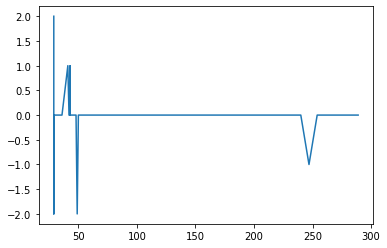

In [21]:
plt.plot(temp.Days, temp['CGI-Change'])
# Negative = Improve
# Positive = Deprove (Increase in CGI) 

--- 
## 2. Loading from Pickle
For subsequent uses, without having to query all over again.

In [38]:
mdd_filter = pd.read_csv('../data/raw_data/Filters/Mdd_Filter.csv', header=None)[0]

In [16]:
#mdd_patients = pickle.load(open('/home/gerpang/VDL/data/intermediate/mdd_patients.pkl','rb'))
# data = pickle.load(open('/home/gerpang/VDL/data/intermediate/full_dataset.pkl','rb'))
data = pickle.load(open('../data/temp/cgi_visits.pkl','rb'))

### Current Patient 

In [18]:
ptX = 458700 # current patient's ID
ptX_data = data.loc[data.PatientID==ptX]

# print(f'''---Current Patient---
# ID: {ptX}
# Age: {ptX_data.Age.max()}
# Sex: {ptX_data.Sex.max()}
# Race: {ptX_data.Sex.max()}
# No. Records: {len(ptX_data)}
# ''')

### 1. CGI over Time

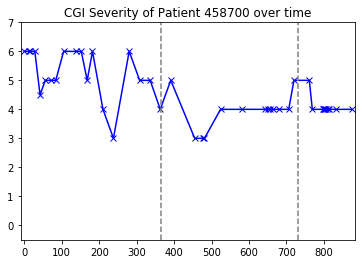

In [19]:
# Patient X's CGI Improvement over time
plt.plot(ptX_data.groupby('Days')['CGI'].mean(), label='Severity', marker='x', color='blue')

ptX_daysmax = ptX_data.Days.max()
for yr in range(ptX_daysmax//365): plt.axvline(x=(yr+1)*365,linestyle='--',c='grey')
plt.axis([-10, ptX_daysmax+10, -0.5,7])
plt.title(f'CGI Severity of Patient {ptX} over time')
plt.savefig('../data/intermediate/cgi_time.png', bbox_inches='tight')
plt.show()

### Comorbidities
1. List the DSM numbers of the patient (and comparative pop) which are not inside the filter list. 
2. Use a separate mapping table to bin the data into the comorbidities list (need to create this)

In [59]:
#Original list of diagnoses for ptX
# pd.DataFrame(ptX_data.Diagnosis.unique(), columns=['Comorbidities'])

## Exclude diagnoses in the mdd_filter
ptX_dsm = pd.DataFrame(ptX_data.DSMNo.unique(), columns=['dsm'])
ptX_dsm[~ptX_dsm.dsm.isin(mdd_filter)]


,dsm
1,V71.09
2,309.81


In [60]:
# Comorbid diseases and number of visits associated with each
ptX_data.groupby('Diagnosis').VisitType.count()

Diagnosis
Major Depressive Disorder, Recurrent, Severe with Psychotic Features    35
No Diagnosis on Axis II                                                 35
Post-Traumatic Stress Disorder                                          35
Name: VisitType, dtype: int64

In [61]:
# Comorbid diseases and days of visits associated with each 
## Tells you when the cormorbidity was diagnosed relative to the disease of interest
ptX_data.groupby('Diagnosis').Days.unique()

Diagnosis
Major Depressive Disorder, Recurrent, Severe with Psychotic Features    [720, 706, 680, 664, 656, 652, 643, 580, 524, ...
No Diagnosis on Axis II                                                 [720, 706, 680, 664, 656, 652, 643, 580, 524, ...
Post-Traumatic Stress Disorder                                          [720, 706, 680, 664, 656, 652, 643, 580, 524, ...
Name: Days, dtype: object

## Comparative Population
Defined as similar primary diagnosis.

In [62]:
pop = data.loc[data.PatientID!=ptX] #[:100000]
pop_mdd = pop.loc[pop.DSMNo.isin(mdd_filter)]

In [63]:
print(f'''
We need to filter for patient records related to MDD-diseases for the medications.
That will narrow the population to {len(pop_mdd)} records.

For comorbidities, we still look at all the records of similar medical profiles,
which means {len(pop)} records.''')


We need to filter for patient records related to MDD-diseases for the medications.
That will narrow the population to 471169 records.

For comorbidities, we still look at all the records of similar medical profiles,
which means 1775628 records.


### CPop % Improved
Using the `pop_mdd` dataset of patients' MDD reocrds:

In [33]:
cpop_meds = pop_mdd.groupby('Medication').agg({'PatientID':'nunique', 'CGI':'mean'})

cpop_improved = pop_mdd.loc[pop['CGI']<=2].groupby('Medication').agg({'PatientID':'nunique', 'CGI':['mean','median','var']})

cpop_all = cpop_meds.merge(cpop_improved, how='left', on='Medication')
cpop_all.columns = ['Count_All','CGI_All','Count_Improved','CGI_Mean','CGI_Median','CGI_Var']
cpop_all['Pct_Improved'] = cpop_all.Count_Improved / cpop_all.Count_All * 100 
cpop_all.sort_values(['Count_All'], ascending=False)

/home/gerpang/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Count_All,CGI-S_All,Count_Improved,CGI-S_Mean,CGI-S_Median,CGI-S_Var,Pct_Improved
Medication,,,,,,,
sertraline,2376,3.736863,626.0,1.294888,1.0,0.208325,26.346801
trazodone,2305,3.984513,489.0,1.259708,1.0,0.193754,21.214751
citalopram,2229,3.859260,573.0,1.339332,1.0,0.224244,25.706595
fluoxetine,2055,4.082384,496.0,1.417091,1.0,0.243221,24.136253
bupropion,1907,3.908563,485.0,1.428980,1.0,0.248323,25.432617
clonazepam,1902,4.023003,394.0,1.431399,1.0,0.245461,20.715037
escitalopram,1883,4.121846,368.0,1.352532,1.0,0.230354,19.543282
aripiprazole,1517,4.284250,262.0,1.200000,1.0,0.165087,17.270929
quetiapine,1495,3.942357,283.0,1.123228,1.0,0.108082,18.929766


[Plotting the Confidence Intervals of Improved Population](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py)

Using Top 10 Medications (by patient count) first: 
- Remove NA
- For each Medication
- plot a boxplot

In [34]:
top10meds = cpop_all.sort_values(['Count_All'], ascending=False).index[:10]
top10meds_cgi = pop_mdd.loc[pop_mdd['Medication'].isin(top10meds)].groupby(['Medication'])['CGI-I'].apply(list)

for i, med in enumerate(top10meds_cgi): 
    top10meds_cgi[i] = [m for m in top10meds_cgi[i] if ~np.isnan(m)] #list(filter(None,top10meds_cgi[i]))
top10meds_cgi

Medication
aripiprazole    [2.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...
bupropion       [0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 4.0, 3.0, ...
citalopram      [4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, ...
clonazepam      [1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 0.0, 4.0, ...
escitalopram    [2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...
fluoxetine      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
quetiapine      [3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 3.0, 2.0, ...
sertraline      [3.0, 3.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 3.0, ...
trazodone       [0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 0.0, 0.0, ...
zolpidem        [0.0, 4.0, 5.0, 0.0, 2.0, 4.0, 5.0, 3.0, 3.0, ...
Name: CGI-I, dtype: object

In [50]:
import statistics

In [57]:
for ix, med in enumerate(top10meds_cgi):
    print(statistics.mean(top10meds_cgi[ix]))

2.9100931381866566
2.7901597285442357
2.6533826674360976
2.9310428143423213
2.8090773103725053
2.711436210159512
2.7158626545666826
2.6834903060368585
2.7443473337815365
2.772139475811107


In [35]:
# Extract percentage improved from the cpop_all dataframe
pct_imp = cpop_all[cpop_all.index.isin(top10meds_cgi.index)]['Pct_Improved']

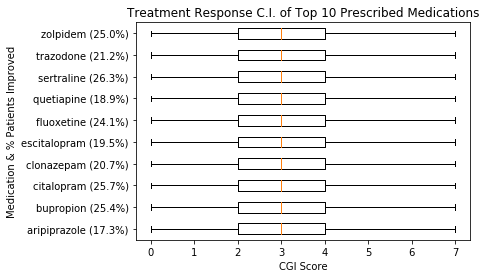

In [36]:
fig, ax = plt.subplots()
bp_data = top10meds_cgi
plt.boxplot(bp_data, vert=False)

ax.set_yticklabels([f'{med_name} ({round(pct,1)}%)' for med_name, pct in zip(top10meds_cgi.index, pct_imp)])
ax.set_title('Treatment Response C.I. of Top 10 Prescribed Medications')
ax.set_ylabel('Medication & % Patients Improved')
ax.set_xlabel('CGI Score')
plt.savefig('../data/intermediate/cgi_improvement.png', bbox_inches='tight')
plt.show()

### CPop Comorbidities

In [39]:
pop_comorbid = pop[~pop.DSMNo.isin(mdd_filter)].groupby(['DSMNo','Diagnosis']).PatientID.nunique()
pd.DataFrame(pop_comorbid).sort_values('PatientID',ascending=False)[:10]

,,PatientID
DSMNo,Diagnosis,
799.9,Diagnosis Deferred on Axis II,6571
309.81,Post-Traumatic Stress Disorder,2334
V71.09,No Diagnosis on Axis II,2324
300.02,Generalized Anxiety Disorder,1925
300.00,Anxiety Disorder NOS,1850
296.90,Mood Disorder NOS,1136
301.83,Borderline Personality Disorder,1054
303.90,Alcohol Dependence,986
296.80,Bipolar Disorder NOS,897


### CPop CGI Against Time
- From Comparative Population (excl PtX) 
- MDD-related records
- For each medication prescribed
- Median +CI CGI scores of patient group over time 

In [16]:
pop_mdd.head(10)

,PatientID,VisitID,VisitName,VisitType,Age,Days,Sex,Race,Diagnosis,DSMNo,Medication,Dose,CGI-I,CGI-S
1,92,1667,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2
5,92,1668,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
9,92,1669,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
13,92,1673,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
17,92,1674,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
21,92,1675,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
25,92,1677,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2
29,92,1679,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
33,92,1681,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
37,92,1691,Progress Note,Outpatient,43,99,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1


### For a particular medication
e.g. buproprion

In [64]:
timeperiod = 120 # days
med_of_interest='bupropion'

meds_within_time = pop_mdd.groupby(['PatientID','Medication']).filter(lambda x:x['Days'].max() - x['Days'].min()<=timeperiod)

# pop_grouped = pop_mdd.groupby(['PatientID','Medication'])
# pop_scaledDays = pop_grouped.Days.apply(lambda x:x-x.min()).filter(lambda x:x['Days'].max() - x['Days'].min()<=timeperiod)
# pop_scaledDays

In [65]:
meds_within_time

,PatientID,VisitID,VisitName,VisitType,Age,Days,Sex,Race,Diagnosis,DSMNo,Medication,Dose,CGI-I,CGI-S
1,92,1667,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2
5,92,1668,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
9,92,1669,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
13,92,1673,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
17,92,1674,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
21,92,1675,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
25,92,1677,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2
29,92,1679,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
33,92,1681,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1
37,92,1691,Progress Note,Outpatient,43,99,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1


In [66]:
meds_within_time['Days_x'] = meds_within_time.groupby(['PatientID','Medication']).Days.apply(lambda x:x-x.min())
meds_within_time = meds_within_time.groupby(['PatientID','Medication']).filter(lambda x:x['Days_x'].max() - x['Days_x'].min()<=timeperiod)
meds_within_time

/home/gerpang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PatientID,VisitID,VisitName,VisitType,Age,Days,Sex,Race,Diagnosis,DSMNo,Medication,Dose,CGI-I,CGI-S,Days_x
1,92,1667,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2,105
5,92,1668,Progress Note,Outpatient,43,105,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,105
9,92,1669,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,104
13,92,1673,Progress Note,Outpatient,43,104,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,104
17,92,1674,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,103
21,92,1675,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,103
25,92,1677,Progress Note,Outpatient,43,103,F,,Depressive Disorder NOS,311,fluoxetine,20.0,1.0,2,103
29,92,1679,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,102
33,92,1681,Progress Note,Outpatient,43,102,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,102
37,92,1691,Progress Note,Outpatient,43,99,F,,Depressive Disorder NOS,311,fluoxetine,20.0,0.0,1,99


In [67]:
med_cgi = meds_within_time[meds_within_time.Medication ==med_of_interest].groupby('Days_x').agg({'CGI':['median','var']})
med_cgi

CGI-S          
       median       var
Days_x                 
0         4.0  1.258338
1         4.0  1.378720
2         4.0  1.225253
3         5.0  1.037003
4         5.0  0.776471
...       ...       ...
116       4.0  0.000000
117       4.0  2.000000
118       2.0  3.900000
119       4.0  2.700000
120       4.0  0.800000

[120 rows x 2 columns]

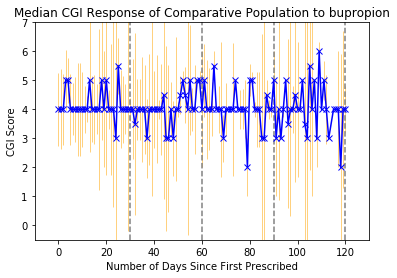

In [68]:
plt.errorbar(med_cgi[('CGI','median')].index,
             med_cgi[('CGI','median')].values, 
             yerr = med_cgi[('CGI','var')],
             color = 'blue',
             marker = 'x',
             ecolor = 'orange', elinewidth=0.5)

for period in np.arange(30, 121, 30): plt.axvline(x=period,linestyle='--',c='grey')
plt.axis([-10, 130, -0.5,7])

plt.title(f'Median CGI Response of Comparative Population to {med_of_interest}')
plt.xlabel('Number of Days Since First Prescribed')
plt.ylabel('CGI Score')
plt.savefig('../data/intermediate/historic_median_cgi.png', bbox_inches='tight')
plt.show()

Made a whoopsie here. should not be everyday of the 120 days, but a single aggregated value. then repeat for 30,60,90 days.

In [69]:
median_vals = []
rng = np.arange(30, 121, 30)
for period in rng:
    print(period)
    cgis_inperiod = meds_within_time[(meds_within_time.Medication ==med_of_interest) &(meds_within_time.Days_x<period)]['CGI']
    results = [cgis_inperiod.mean(), cgis_inperiod.median(), cgis_inperiod.std()]
    median_vals.append(results)

median_df = pd.DataFrame(median_vals, columns=['Mean','Median','Std'])


30
60
90
120


In [70]:
median_df

,Mean,Median,Std
0,4.204316,4.0,1.159102
1,4.151039,4.0,1.179023
2,4.147880,4.0,1.173008
3,4.141806,4.0,1.188229


In [71]:
median_df['Std']

0    1.159102
1    1.179023
2    1.173008
3    1.188229
Name: Std, dtype: float64

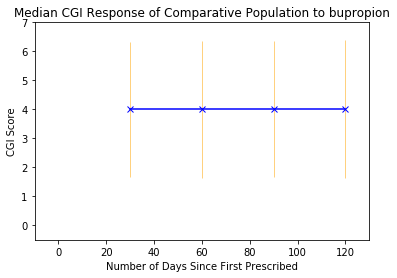

In [72]:
plt.errorbar(rng, median_df['Median'],
             yerr = median_df['Std'] *2,
             color = 'blue',
             marker = 'x',
             ecolor = 'orange', elinewidth=0.5)

plt.axis([-10, 130, -0.5,7])
plt.title(f'Median CGI Response of Comparative Population to {med_of_interest}')
plt.xlabel('Number of Days Since First Prescribed')
plt.ylabel('CGI Score')
plt.savefig('../data/intermediate/historic_median_cgi_binned.png', bbox_inches='tight')
plt.show()

This graph looks super useless. but it is the described way inthe paper.

### Interactive

In [73]:
# import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [74]:
meds_list = pop_mdd['Medication'].unique()[:10]

In [100]:
@interact
def show_meds_CGIbyDays(med=meds_list, x=365):

    temp = pop_mdd.loc[pop_mdd.Medication == med].groupby('Days').agg({'CGI':'median'})
    return temp.loc[temp.index<x]


interactive(children=(Dropdown(description='med', options=('fluoxetine', 'clorazepate', 'sertraline', 'bupropi…